# ADS 509 Assignment 6.1 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords
sw = stopwords.words("english")

In [2]:
# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter"
lyrics_folder = "lyrics"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

In [3]:
# Function to find directory
def find_directory(target_dir, start_path='.') :
    
    for root, dirs, files in os.walk(start_path) :
        if target_dir in dirs :
            path = os.path.join(root, target_dir)
            
    return path

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_list = []
lyrics_path = find_directory(lyrics_folder)

for artist in os.listdir(lyrics_path) :
    artist_path = os.path.join(lyrics_path, artist)
    
    # Check if it is a directory
    if os.path.isdir(artist_path) :
        for filename in os.listdir(artist_path) :
            
            if filename.endswith('.txt') :
                title = filename.split('_')[1].replace(".txt", "")
                
                file_path = os.path.join(artist_path, filename)
                lyrics = open(file_path, 'r').read()
                
                lyrics_list.append([artist, title, lyrics])

lyrics_data = pd.DataFrame(lyrics_list, columns=['artist', 'song_title', 'lyrics'])

In [5]:
lyrics_data.head()

,artist,song_title,lyrics
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n..."
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if..."
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ..."
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ..."
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."


In [6]:
# Read in the twitter data
twitter_path = find_directory(twitter_folder)
twitter_files = os.listdir(twitter_path)
twitter_files = [f for f in twitter_files if 'followers_data' in f]

# Dictionary of lists to store the description
twitter_desc = defaultdict(list)

for file in twitter_files :
    data_path = os.path.join(twitter_path, file)
    artist = file.split('_')[0]
    
    with open(data_path, 'r', encoding='utf-8') as txtfile:
        # skipping the column header
        next(txtfile)
        
        for idx, line in enumerate(txtfile.readlines()):
            line = line.strip().split('\t')
            
            # Check if the line has 7 columns
            if len(line) == 7:
                twitter_desc[artist].append(line[6])

In [7]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Dictionary to hold positive and negative words with scores
word_dict = {}

# Read in the positive words
with open(positive_words_file, 'r') as pos_file :
    # Iterate through each line
    for line in pos_file :
        line = line.strip()
        
        # Skip lines that are empty or start with ';'
        if not line or line.startswith(';') :
            continue
        # Assigning score of +1 to positive words
        word_dict[line] = 1
        
# Read in the negative words
with open(negative_words_file, 'r') as neg_file :
    
    for line in neg_file :
        line = line.strip()
        
        if not line or line.startswith(';') :
            continue
        # Assigning score of -1 to negative words
        word_dict[line] = -1

# Read in the tidytext sentiment
sentiments_data = pd.read_csv(tidy_text_file, sep='\t')
sentiments_data.head()

,word,sentiment,lexicon
0,abandon,negative,nrc
1,abandoned,negative,nrc
2,abandonment,negative,nrc
3,abba,positive,nrc
4,abduction,negative,nrc


## Data Cleaning - Tokenization and normalization

In [8]:
punctuation = set(punctuation)
tw_punct = punctuation - {"#"}

# Function to clean data
def get_cleaned_tokens(text) :
    
    # Removing punctuation
    words = "".join([char for char in text if char not in tw_punct])
    
    # Case folding and tokenization
    words = [token.lower().strip() for token in words.split()]
    
    # Removing stop words
    words = [token for token in words if token not in sw]
    
    return(words)

In [9]:
lyrics_data['tokens'] = lyrics_data['lyrics'].apply(get_cleaned_tokens)

# After tokenization and normalization
lyrics_data.head()

,artist,song_title,lyrics,tokens
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h..."
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa..."
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i..."
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, dont, ..."
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor..."


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [10]:
# Function to calculate sentiment score
def get_sentiment_score(tokens) :
    score = 0
    for word in tokens :
        if word in word_dict :
            score += word_dict[word]
    
    return score

In [11]:
# calls to calculate sentiment score
lyrics_data['sentiment_score'] = lyrics_data['tokens'].apply(get_sentiment_score)

In [12]:
lyrics_data.head()

,artist,song_title,lyrics,tokens,sentiment_score
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...","[88, degrees, stuck, la, aint, got, friends, h...",3
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if...","[different, kind, love, song, world, crazy, sa...",17
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ...","[well, guess, must, fate, weve, tried, deep, i...",-1
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ...","[evening, finds, door, ask, could, try, dont, ...",1
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...","[alfie, whats, alfie, moment, live, whats, sor...",7


### Questions

**Q: Overall, which artist has the higher average sentiment per song?**

A: Based on the output below, Cher has a higher average sentiment per song compared to Robyn

In [13]:
artist_avg_sentiment = lyrics_data.groupby('artist')['sentiment_score'].mean()

print("Artist with highest average sentiment:", artist_avg_sentiment.idxmax())

Artist with highest average sentiment: cher


**Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?**

A: The three songs with the highest sentiment scores are 'Perfection', 'My Love', and 'Love and Understanding.' In contrast, the songs with the lowest sentiment scores are 'I Walk on Guilded Splinters,' 'Outrageous,' and 'Dressed to Kill.'

The sentiment score for each song is mainly influenced by the presence of positive or negative words in the sentiment lexicon. The highest-scoring songs include multiple positive words like "perfection," "good," "best," and "love," which collectively boost the sentiment score. On the other hand, the songs with the lowest sentiment scores frequently feature negative words such as "kill," "fall," "outrageous," and "burn," which contribute to a decrease in the sentiment score.

In [14]:
# Cher lyrics sentiment score
cher_sentiment_df = lyrics_data[lyrics_data['artist'] == "cher"]

# Sort the score in descending order
cher_sentiment_df = cher_sentiment_df.sort_values(by='sentiment_score', ascending=False)

cher_highest_sentiment = cher_sentiment_df.head(3)
cher_lowest_sentiment = cher_sentiment_df.tail(3)

In [15]:
# Printing highest sentiment song lyrics
for index, row in cher_highest_sentiment.iterrows() :
    print(f"Lyrics: {row['lyrics']}")

Lyrics: "Perfection"



Hush little Baby, gotta be strong
'Cause in this world we are born to fight
Be the best, prove them wrong
A winner's work is never done, reach the top, number one

Oh, perfection
You drive me crazy with perfection
I've worn my pride as my protection
Perfection, ohh

I was taught to be tough
That the best that you can be ain't enough
Crack the whip, sacrifice
But I found out paradise had a price

I didn't know it then, but oh I know it now
You gotta work as hard as love to make the love work out
You know this heart of mine has made some big mistakes
I guess that when it comes to love, I just don't know what I takes

All my life I've been driven by perfection
Pushed it to the limit every day and night
Ohh, I've been driven by perfection
But nothing's perfect when love ain't right
Nothing's perfect when the love ain't right

Gave it all, played my part
I gave everything I had but my heart
Worked so hard, made a name
But the loneliness inside stays the same

When lo

In [16]:
# Printing lowest sentiment song lyrics
for index, row in cher_lowest_sentiment.iterrows() :
    print(f"Lyrics: {row['lyrics']}")

Lyrics: "Dressed To Kill"



I slip into my shoes and slide into the night
I'm on the loose you're in my sights
You know it's gonna hurt you but it's just no use
You fall in love they always do
And I'm waiting for the next one to fall

I'm dressed to kill and you know that I will
We're dancing in the dark with my hands around your heart
Oh, heads will roll and blood will spill
But how can you resist when baby I am dressed to kill

I know your love is strong but it's all it in vain
Beware the skies the lipstick stains
And he can't even see that he's just another one
It's far too late he's too far gone
And I'm waiting for the next one to fall

I'm dressed to kill and you know that I will
We're dancing in the dark with my hands around your heart
Oh, heads will roll and blood will spill
But how can you resist when baby I am dressed to kill

How can you resist when baby I am dressed to kill

You know I'm the only one
I can make you come undone
And you'll be part of me
From now until eternit

**Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?** 

A: The three songs with the highest sentiment scores are "Love Is Free," followed by "Indestructible" and "U Should Know Better," which appears twice. In contrast, the songs with the lowest sentiment scores include "Don't Fucking Tell Me What To Do" (appearing twice), "Criminal Intent," and "Crash And Burn Girl."

The sentiment score of each song is primarily driven by the occurrence of positive or negative words from the sentiment lexicon. Songs with higher scores tend to feature multiple positive words like "love" and "better," which elevate the sentiment. Conversely, the lowest-scoring songs often contain negative words such as "crashing," "burn," "criminal," and "killing," leading to a lower overall sentiment score.

In [17]:
# Robyn lyrics sentiment score
robyn_sentiment_df = lyrics_data[lyrics_data['artist'] == "robyn"]

# Sort the score in descending order
robyn_sentiment_df = robyn_sentiment_df.sort_values(by='sentiment_score', ascending=False)

robyn_highest_sentiment = robyn_sentiment_df.head(4)
robyn_lowest_sentiment = robyn_sentiment_df.tail(4)

In [18]:
# Printing highest sentiment song lyrics
for index, row in robyn_highest_sentiment.iterrows() :
    print(f"Lyrics: {row['lyrics']}")

Lyrics: "Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

I'ma give it to you, baby
I'ma give it when I'm ready
Some lose, some steady
Some light, some heavy
It's all over this city
Sometimes in the ugly, sometimes in the pretty
You never know where you get it cause you can't control it and you can't unfold it, slow down

Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Yeah! Yeah! Yeah! Yeah!
Love is free, b

In [19]:
# Printing lowest sentiment song lyrics
for index, row in robyn_lowest_sentiment.iterrows() :
    print(f"Lyrics: {row['lyrics']}")

Lyrics: "Crash And Burn Girl"



I should write a song about you and all the shit that you do
You don't even know what's up
But soon it all comes crashing down on you
Since we're on the subject
tell me why your name's in the dictionary when I look up idiot
Check yourself, it's very necessary

Get up shake your rump girl
Cause this track is for you
And baby this is not a love song

Stop listen what's that sound
Supersonic spinning round
You don't mind the fall 
until your face hits the ground

Crash and burn girl
goin' down down down down down
Crash and burn girl
You don't mind the fall 
until your face hits the ground

You should have a sticker on you saying Warning Keep Out
You're the kind of girl that'll mess you up for life
that's smashing up his car
crying on his doorstep
waiting in the rain all night
And did you tell him you're the kind that
never show your ugly side until you sticking like glue
Shit you even go down on him
though he never do it for you
Time to clear the runway fo

**Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.**



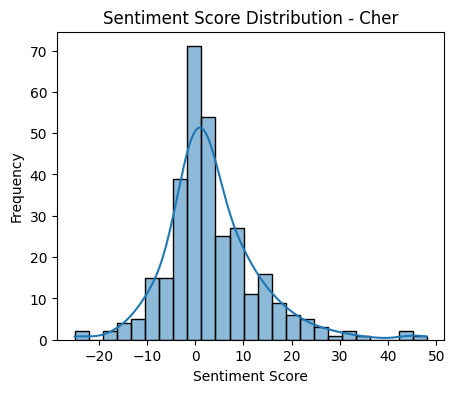

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram distribution of Sentiment Score for Cher 
plt.figure(figsize=(5,4))
sns.histplot(data=cher_sentiment_df, x="sentiment_score", kde=True)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Score Distribution - Cher")
plt.show()

The distribution in the plot is right-skewed, indicating that there are fewer instances of highly positive sentiment, with the majority of data points clustered around neutral or slightly negative sentiment. Most of Cher's lyrics exhibit a neutral to mildly positive sentiment, with the bulk of sentiment scores ranging between -5 and 10.

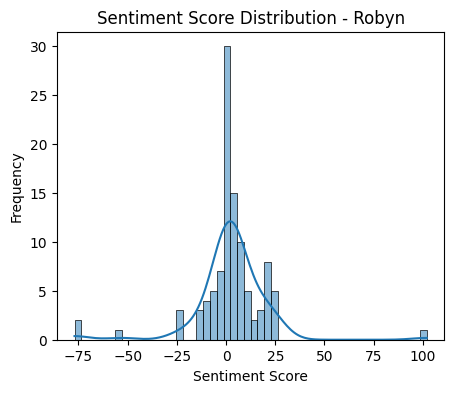

In [22]:
# Histogram distribution of Sentiment Score for Robyn
plt.figure(figsize=(5,4))
sns.histplot(data=robyn_sentiment_df, x="sentiment_score", kde=True)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Sentiment Score Distribution - Robyn")
plt.show()

The plot indicates that Robyn's sentiment distribution is neutral, with the majority of values centered around 0. Negative sentiment occurs more frequently than positive sentiment, and although there are a few extreme values on both the negative and positive sides, they are quite rare.

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [82]:
# Defining positive and negative emojis
positive_emojis = {'❤️': 1, '😍': 1, '😊': 1, '😎': 1, '👍': 1, '👌': 1, '😘': 1, '💪': 1, '🙏': 1, '👏': 1}
negative_emojis = {'😒': -1, '😭': -1, '💔': -1, '😢': -1, '😠': -1, '👎': -1, '😞': -1, '😡': -1, '😶': -1, '😟': -1}

In [79]:
# Function to extract emojis
def extract_emojis(text):
    return ''.join([char for char in text if char in emoji.EMOJI_DATA])

# Function that calculates emoji sentiment score
def get_emoji_score(emojis) :
    pos_score = 0
    neg_score = 0
    
    for em in emojis :
        if em in positive_emojis :
            pos_score += positive_emojis[em]
        elif em in negative_emojis :
            neg_score += negative_emojis[em]
            
    return pos_score + neg_score
    
# Function that calculates average sentiment for artists
def get_average_sentiment(description) :
    follower_count = 0
    emoji_sentiment_score = 0
    
    for desc in description:
        emojis = extract_emojis(desc)
        
        if(len(emojis) != 0):
            follower_count += 1
            emoji_sentiment_score += get_emoji_score(emojis)

    return  emoji_sentiment_score/follower_count

**Q: What is the average sentiment of your two artists?**

A: The average Sentiment for Cher and Robyn are 0.1002 and 0.0558.

In [83]:
for artist, description in twitter_desc.items() :
    avg_sentiment_score = get_average_sentiment(description)
    print(f'Average Sentiment score for {artist} is {avg_sentiment_score}')
    print()

Average Sentiment score for cher is 0.10020157391882478

Average Sentiment score for robynkonichiwa is 0.05581102128606393



**Q: Which positive emoji is the most popular for each artist? Which negative emoji?**

A: The most popular positive and negative emoji for Cher is 😍 and 💔. The most popular positive and negative emoji for Robyn is 😎 and 💔.


In [69]:
def most_popular_emoji(description) :

    # Extracting positive and negative emojis
    artist_positive_emojis = [emoji for desc in description for emoji in desc if emoji in positive_emojis]
    artist_negative_emojis = [emoji for desc in description for emoji in desc if emoji in negative_emojis]

    # Counting the emojis and extracting the top emoji
    most_popular_pos_emoji = Counter(artist_positive_emojis).most_common(1)[0][0]
    most_popular_neg_emoji = Counter(artist_negative_emojis).most_common(1)[0][0]

    return most_popular_pos_emoji, most_popular_neg_emoji
    

In [84]:
for artist, description in twitter_desc.items() :
    popular_pos_emoji,popular_neg_emoji  = most_popular_emoji(description)
    print(f"For artist {artist}")
    print(f"Most popular positive emoji: {popular_pos_emoji}")
    print(f"Most popular negative emoji: {popular_neg_emoji}")
    print()

For artist cher
Most popular positive emoji: 😍
Most popular negative emoji: 💔

For artist robynkonichiwa
Most popular positive emoji: 😎
Most popular negative emoji: 💔

